In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as utils

from tqdm.notebook import tqdm, trange

# set random seeds for reproducibility
# torch.manual_seed(0)
# np.random.seed(0)

import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim

from numpy import linalg as LA
from scipy.sparse import random as sparserand



# Setup the ability to run on a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


def create_reservoir_matrix(size=(10,10), spectral_radius=0.9, sparsity=0.5):
    """ Creates the W_res of the ESN which has the ESP
    inputs: 
    size: square matrix representing the size of teh reservoir connections
    spectral_radius: largest eigenvalue in reservoir matrix should be <1
    sparsity: connectivity of matrix, 1.0 indicates full connection 
    """
    # generate uniformly random from U[0,1] *2 -1 makes it U[-1,1]
    W_res = torch.rand(size)#*2-1

    # create a sparse mask array then multiply reservoir weights by sparse mask
    # sparse mask is done by generating uniform[0,1] then setting True <=sparsity
    W_res = W_res*(torch.rand_like(W_res) <= sparsity).type(W_res.dtype)
    
    # scale the matrix to have the desired spectral radius
    W_res = W_res*spectral_radius/(np.max(np.abs(np.linalg.eigvals(W_res))))

    return W_res.float()


def create_sparse_connection_matrix(size=(10,10),spectral_radius=0.9, sparsity=0.5):
  """ Creates a sparse matrix using a different library which is not probabilistic
  and so should have a better consistency for small networks 
  returns a numpy array"""
  matrix = sparserand(size[0],size[1], density=sparsity)
  matrix = matrix.A*2-1 # shift from U[0,1] to U[-1,1]

  max_eigval = max(abs(LA.eigvals(matrix.A)))
  if max_eigval == 0:
    # checks for an entirely sparse matrix
    return matrix.A

  else:
    matrix = spectral_radius*matrix.A/max_eigval
    return matrix

class Reservoir(nn.Module):
	def __init__(self, n_hidden):
		super(Reservoir, self).__init__()
		self.h = torch.rand((n_hidden, 1))
		self.W_res = create_reservoir_matrix(size=(n_hidden, n_hidden), spectral_radius=0.95, sparsity=0.05)

		self.W_res.requires_grad = False

	def forward(self):
		# self.h = torch.tanh(torch.mm(self.W_res, self.h))
		self.h = torch.tanh(torch.mm(self.W_res, self.h))
		output = torch.tanh(torch.mm(self.W_res, self.h))
		return output.transpose_(0, 1)

class ESN(nn.Module):
    def __init__(self, input_size, n_hidden):
        super(ESN, self).__init__()
        self.input_size = input_size
        self.n_hidden = n_hidden

        self.W_in = nn.Linear(input_size, n_hidden)
        self.W_res = Reservoir(n_hidden)
        self.W_readout = nn.Linear(n_hidden, 1)

        self.W_in.weight.requires_grad = False
        self.W_in.bias.requires_grad = False

    def forward(self, input):
	    o_input = self.W_in(input).to(device)
	    o_res = self.W_res().to(device)
	    output = o_input + o_res
	    output = self.W_readout(output).to(device)

	    return output.flatten()


class MultDataset(Dataset):
	def __init__(self, size):
		self.size = size
		self.data = np.random.randint(1, 100, size=(size,2))
		scaler = MinMaxScaler()
		self.data = scaler.fit_transform(self.data)
		self.data = np.hstack((self.data, np.multiply(self.data[:, 0], self.data[:, 1]).reshape((size, 1))))
		
	def __len__(self):
		return self.size
	
	def __getitem__(self, item):
		if torch.is_tensor(item):
			item = item.tolist()
			
		return torch.from_numpy(self.data[item, :2]), torch.from_numpy(np.asarray(self.data[item, 2]))


class ANDDataset(Dataset):
	def __init__(self):
		self.data = np.asarray([[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 1]])

	def __len__(self):
		return 4

	def __getitem__(self, item):
		if torch.is_tensor(item):
			item = item.tolist()

		return torch.from_numpy(self.data[item, :2]), torch.from_numpy(np.asarray(self.data[item, 2]))


# torch.manual_seed(0)
# np.random.seed(0)

LEARN_TIME = 40
READOUT_TIME = 5

# Hyper Parameters 
num_epochs = 1500
batch_size_train = 100
batch_size_val = 100
batch_size_test = 10
learning_rate = 0.01
weight_decay = 0.01
dataset_size = 10000

# input parameters
input_size = 2

# Hyper-parameters
n_hidden = 150

model = ESN(input_size, n_hidden)

saved_res = model.W_res.W_res
saved_in = model.W_in

test_dataset = MultDataset(10)
train_dataset, val_dataset = torch.utils.data.random_split(MultDataset(dataset_size), (int(0.9*dataset_size), int(0.1*dataset_size)))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# move to the GPU
model.to(device)

optimizer = optim.Adam(model.W_readout.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

mse = nn.MSELoss()

epoch_train_losses = []
epoch_val_losses = []
old = 0

learned = []

for epoch in trange(num_epochs):
	train_losses = 0
	val_losses = 0
	num_steps = 0
	model.train()

	for i, (inputs, labels) in enumerate(train_loader):
		# inputs = inputs.view(1, input_size)
		np_inputs = inputs.numpy()
		np_labels = labels.numpy()
		inputs = inputs.float()
		inputs = inputs.to(device)
		labels = labels.float().to(device)

		optimizer.zero_grad()

		for learn in range(LEARN_TIME):
			output = model(inputs).flatten()
			# print(torch.sum(output - old))
			# learned.append(torch.sum(output - old))
			old = output

		outputs = 0
		for read in range(READOUT_TIME):
			output = model(inputs).flatten()
			# print(torch.sum(output))
			outputs += output
		outputs = outputs / READOUT_TIME

		batch_train_loss = mse(outputs, labels) / batch_size_train
		train_losses += batch_train_loss.item()
		
		batch_train_loss.backward()

		optimizer.step()

		num_steps += 1

	scheduler.step(train_losses/num_steps)

	epoch_train_losses.append(train_losses/num_steps)


	num_steps = 0
	model.eval()
	for i, (inputs, labels) in enumerate(val_loader):
		inputs = inputs.float()
		inputs = inputs.to(device)
		labels = labels.float().to(device)

		for learn in range(LEARN_TIME):
			output = model(inputs).flatten()

		outputs = 0
		for read in range(READOUT_TIME):
			output = model(inputs).flatten()
			outputs += output
		outputs = outputs / READOUT_TIME

		batch_val_loss = mse(outputs, labels) / batch_size_val
		val_losses += batch_val_loss.item()

		num_steps += 1

	epoch_val_losses.append(val_losses/num_steps)

cuda:0
Epoch    13: reducing learning rate of group 0 to 1.0000e-03.
Epoch    27: reducing learning rate of group 0 to 1.0000e-04.
Epoch    45: reducing learning rate of group 0 to 1.0000e-05.
Epoch    61: reducing learning rate of group 0 to 1.0000e-06.
Epoch    79: reducing learning rate of group 0 to 1.0000e-07.
Epoch    90: reducing learning rate of group 0 to 1.0000e-08.



In [ ]:
# plt.plot(learned)

In [ ]:
plt.plot(epoch_train_losses, color='blue')
print(sum(epoch_train_losses[-10:])/10)

In [ ]:
plt.plot(epoch_val_losses, color='orange')

In [ ]:
for i, (inputs, labels) in enumerate(test_loader):
	inputs = inputs.float().to(device)
	labels = labels.float().to(device)

	for learn in range(LEARN_TIME):
		output = model(inputs).flatten()

		outputs = 0
		for read in range(READOUT_TIME):
			output = model(inputs).flatten()
			# print(output)
			outputs += output.item()
		outputs = outputs / READOUT_TIME

	print(inputs, round(outputs, 2), '\t', labels.item(), round(np.square(outputs - labels.item()), 5))

In [ ]:
print(torch.sum(model.W_res.W_res - saved_res))
print(torch.sum(model.W_in.weight - saved_in.weight))

In [ ]:
# for i, (inputs, labels) in enumerate(train_loader):
# 	inputs = inputs.float().to(device)
# 	labels = labels.float().to(device)
#
# 	for learn in range(LEARN_TIME):
# 		output = model(inputs).flatten()
#
# 		outputs = 0
# 		for read in range(READOUT_TIME):
# 			output = model(inputs).flatten()
# 			# print(output)
# 			outputs += output
# 		outputs = outputs / READOUT_TIME
#
# 	print(inputs, outputs.item(), labels.item())

In [3]:
# for i, (inputs, labels) in enumerate(train_loader):
# 	inputs = inputs.float().to(device)
# 	labels = labels.float().to(device)
#
# 	for learn in range(LEARN_TIME):
# 		output = model(inputs).flatten()
#
# 		outputs = 0
# 		for read in range(READOUT_TIME):
# 			output = model(inputs).flatten()
# 			# print(output)
# 			outputs += output
# 		outputs = outputs / READOUT_TIME
#
# 	print(inputs, outputs.item(), labels.item())

7.168538042606088e-05


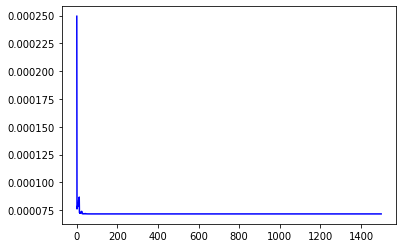

In [4]:
plt.plot(epoch_train_losses, color='blue')
print(sum(epoch_train_losses[-10:])/10)

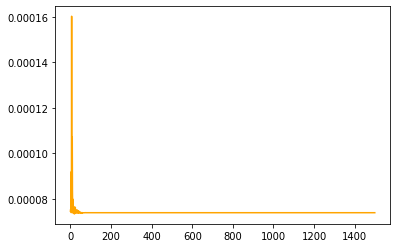

In [5]:
plt.plot(epoch_val_losses, color='orange')

In [9]:
for i, (inputs, labels) in enumerate(test_loader):
	inputs = inputs.float().to(device)
	labels = labels.float().to(device)

	for learn in range(LEARN_TIME):
		output = model(inputs).flatten()

		outputs = 0
		for read in range(READOUT_TIME):
			output = model(inputs).flatten()
			# print(output)
			outputs += output.item()
		outputs = outputs / READOUT_TIME

	print(inputs, round(outputs, 2), '\t', labels.item(), round(np.square(outputs - labels.item()), 5))

tensor([[0.9123, 0.5412]], device='cuda:0') 0.48 	 0.4937048554420471 0.00021
tensor([[0.7895, 0.6706]], device='cuda:0') 0.48 	 0.529411792755127 0.00233
tensor([[0.2807, 0.0353]], device='cuda:0') -0.09 	 0.00990712083876133 0.00941
tensor([[0.1053, 1.0000]], device='cuda:0') 0.3 	 0.10526315867900848 0.0377
tensor([[0.4211, 0.1882]], device='cuda:0') 0.06 	 0.07925696671009064 0.00042
tensor([[1.0000, 0.9765]], device='cuda:0') 0.74 	 0.9764705896377563 0.0571
tensor([[0.3509, 0.9059]], device='cuda:0') 0.38 	 0.3178534507751465 0.00345
tensor([[0., 0.]], device='cuda:0') -0.25 	 0.0 0.0603
tensor([[0.9825, 0.3882]], device='cuda:0') 0.44 	 0.3814241588115692 0.00334
tensor([[0.9825, 0.0588]], device='cuda:0') 0.28 	 0.057791538536548615 0.04811


In [7]:
print(torch.sum(model.W_res.W_res - saved_res))
print(torch.sum(model.W_in.weight - saved_in.weight))

tensor(0.)
tensor(0., device='cuda:0')


In [8]:
# for i, (inputs, labels) in enumerate(train_loader):
# 	inputs = inputs.float().to(device)
# 	labels = labels.float().to(device)
#
# 	for learn in range(LEARN_TIME):
# 		output = model(inputs).flatten()
#
# 		outputs = 0
# 		for read in range(READOUT_TIME):
# 			output = model(inputs).flatten()
# 			# print(output)
# 			outputs += output
# 		outputs = outputs / READOUT_TIME
#
# 	print(inputs, outputs.item(), labels.item())